In [ ]:
!pip install scienceplots

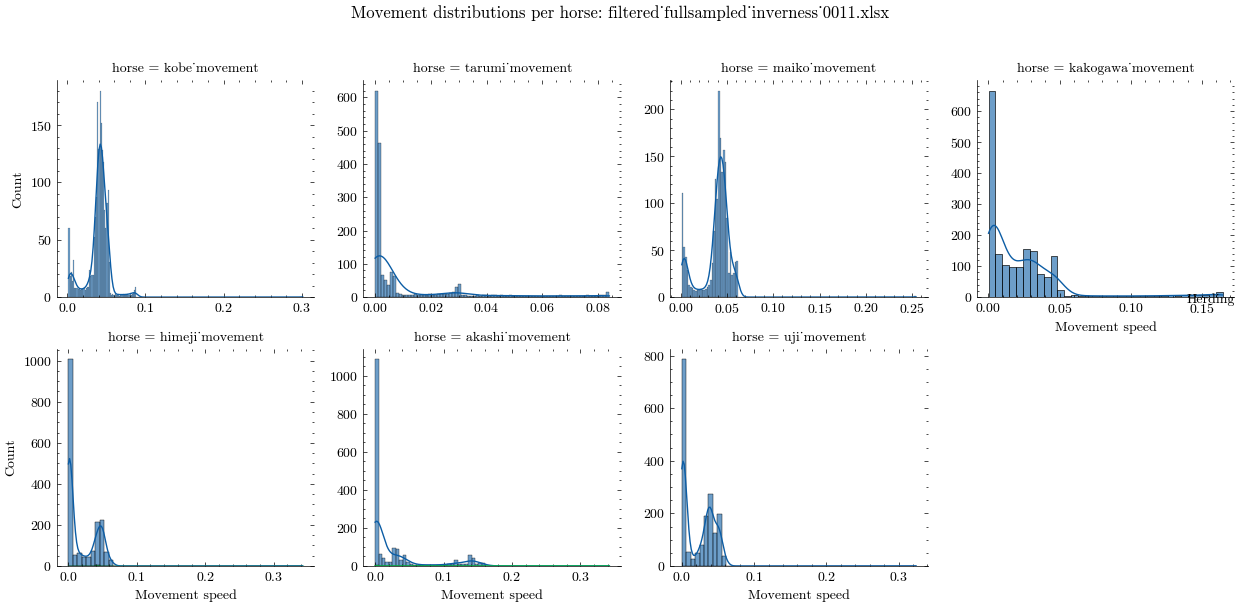

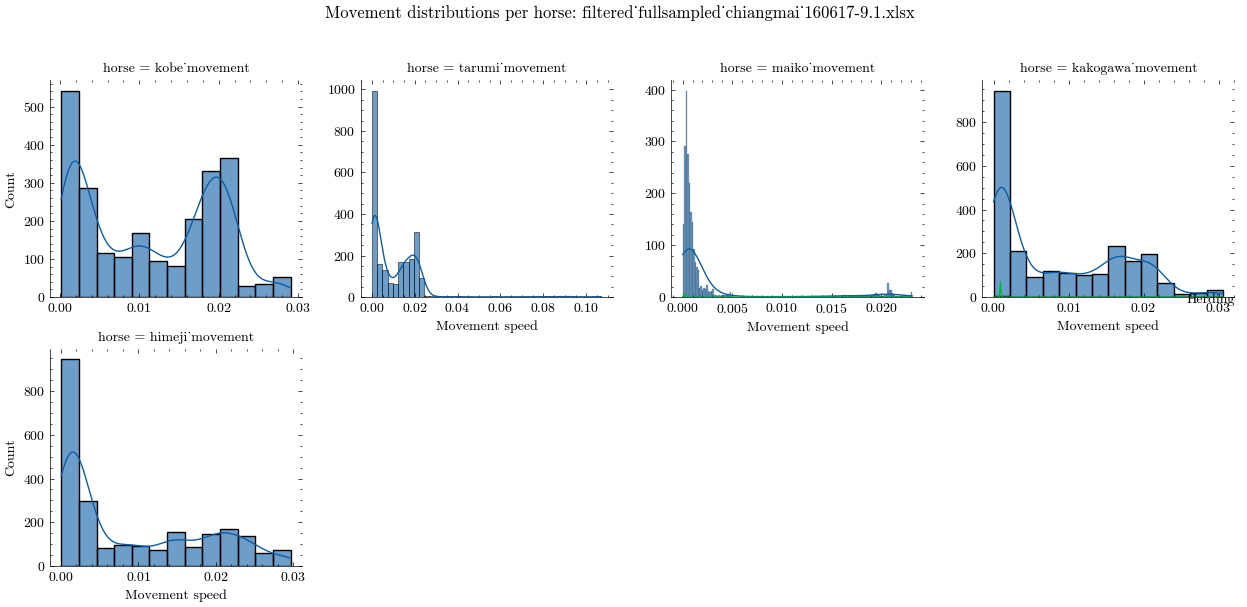

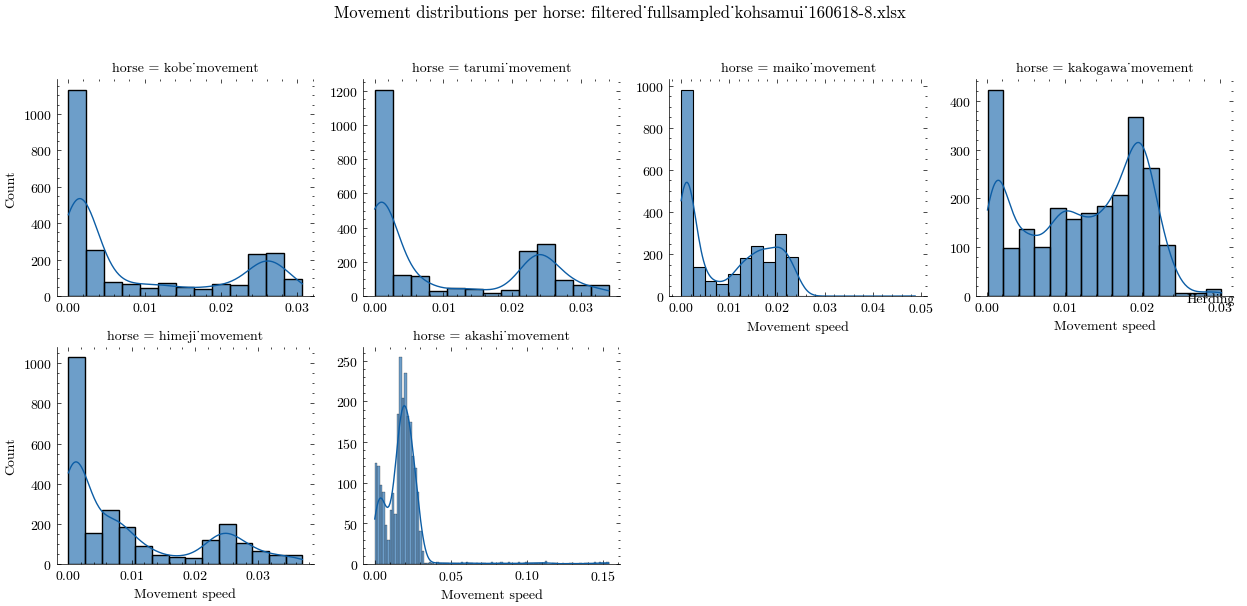

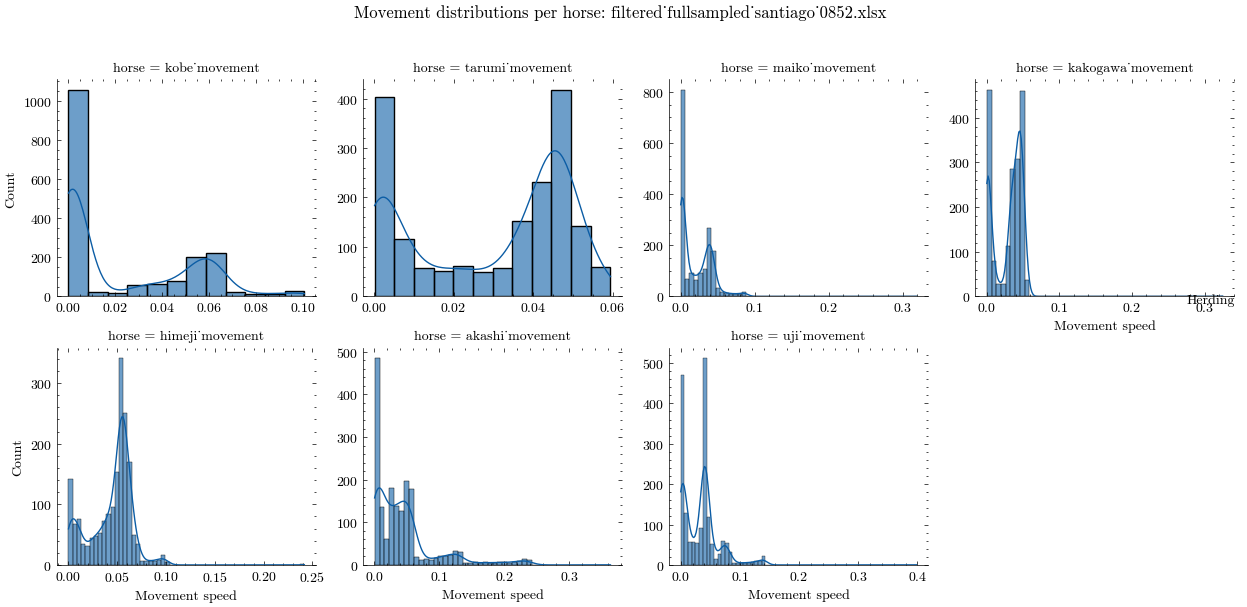

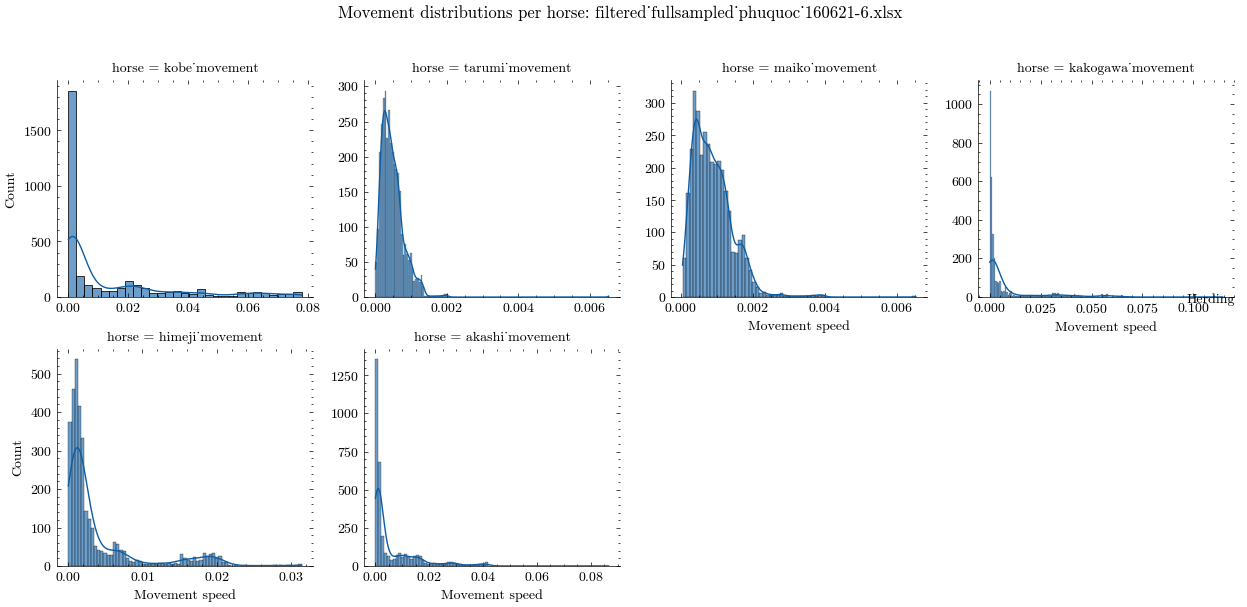

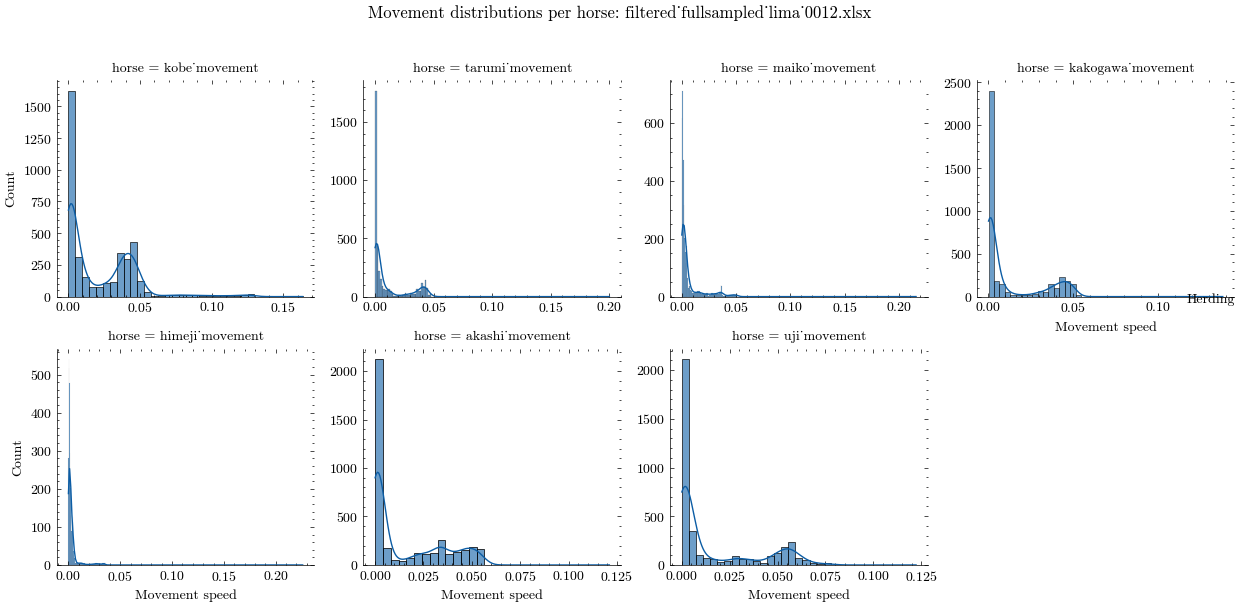

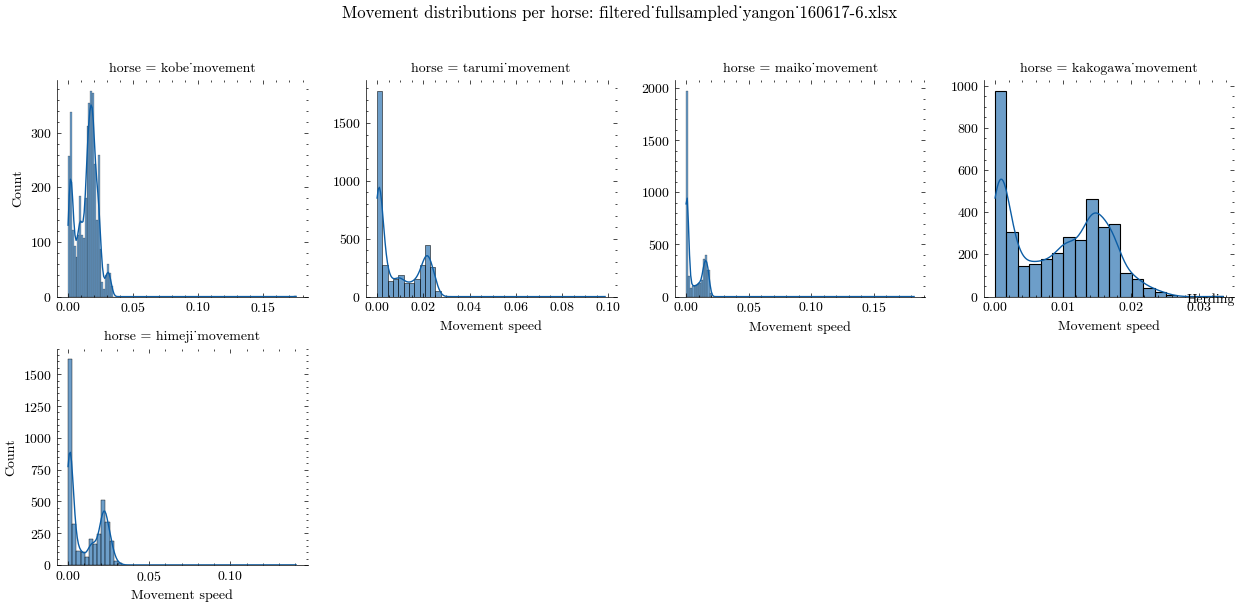

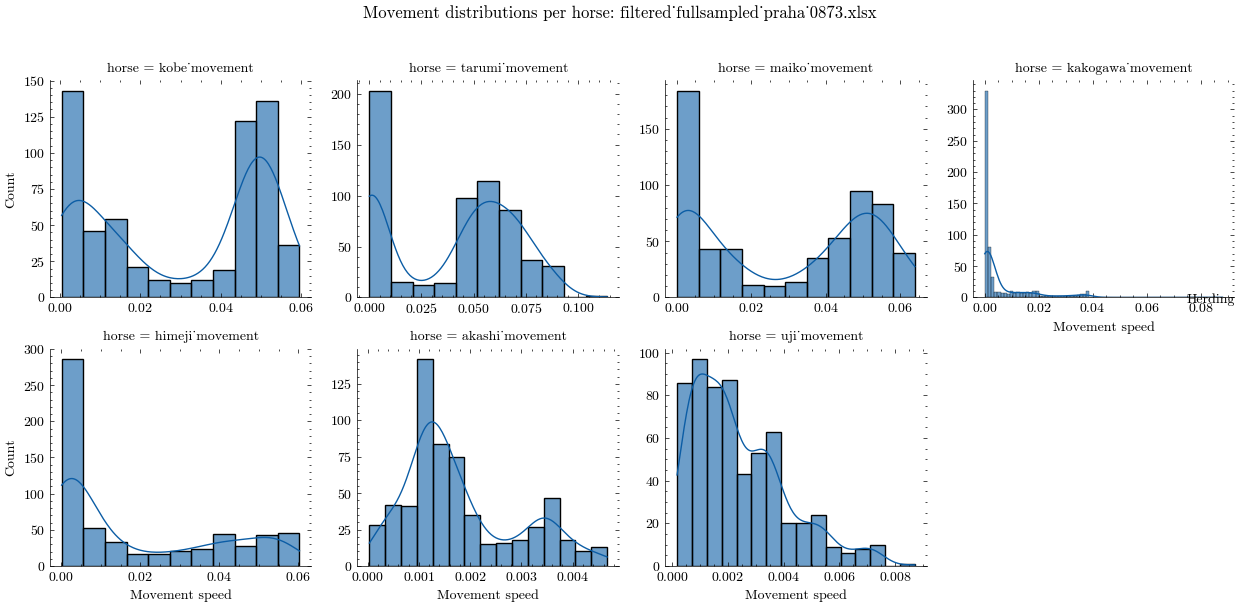

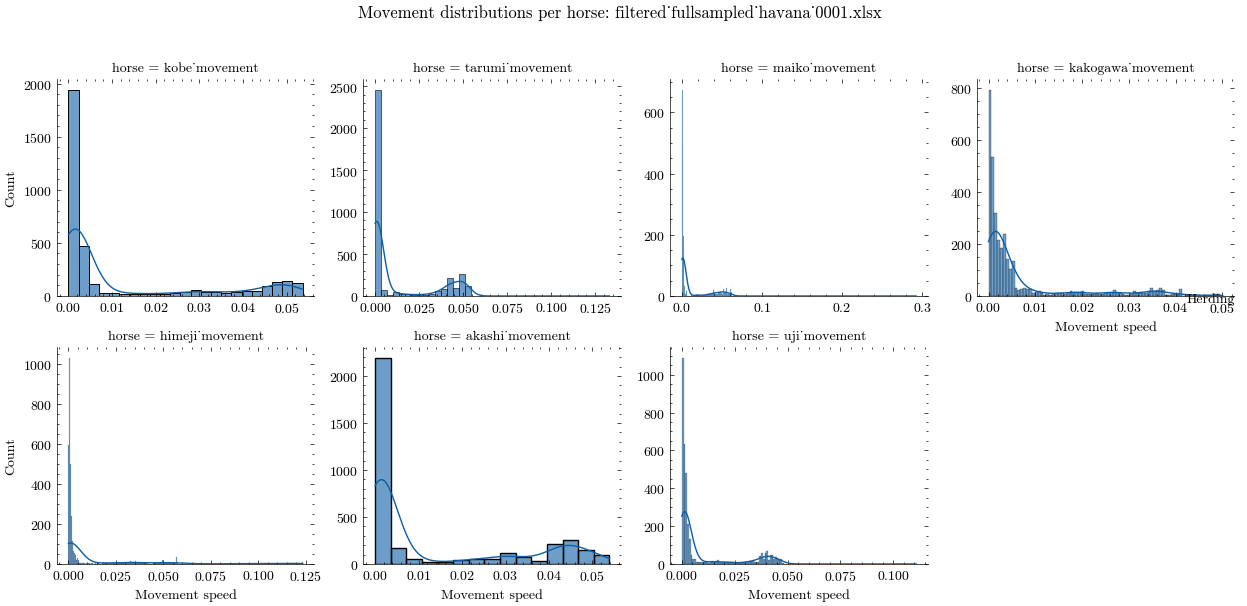

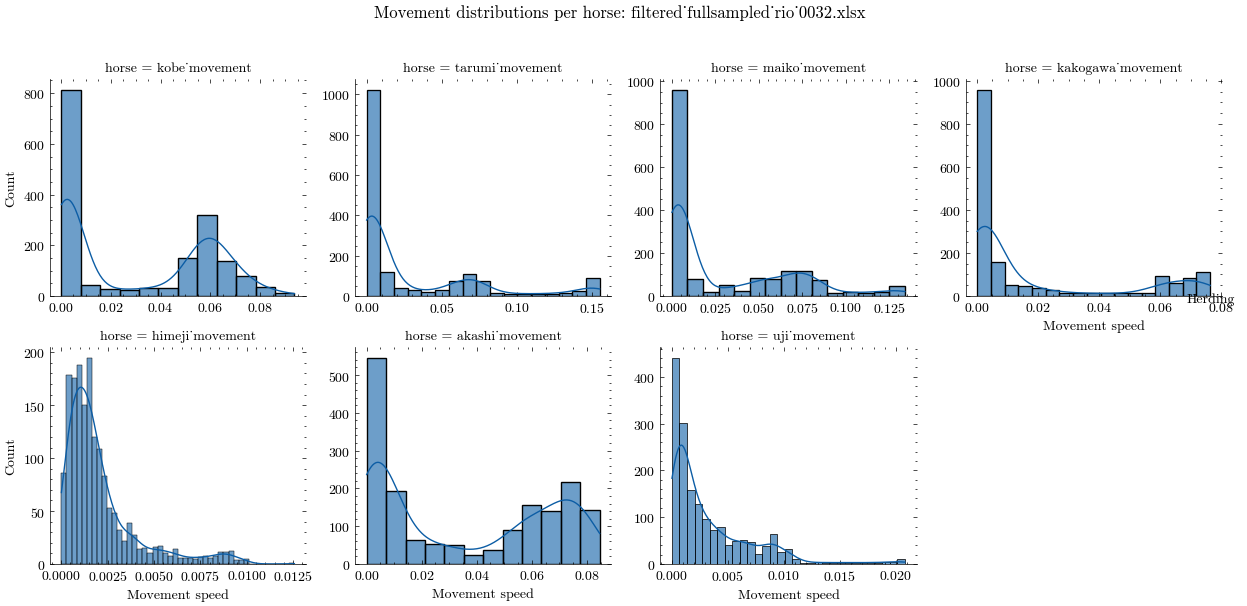

In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist          # ← import pdist here
from openpyxl import load_workbook
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
plt.style.use(["science", "no-latex"])

# Functions as defined by the user
def read_excel_data_with_colors(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path)
                 if f.endswith('.xlsx') or f.endswith('.xls')]
    data_frames = {}
    for file in all_files:
        # Read data with pandas
        df = pd.read_excel(file)
        # Read colors using openpyxl
        wb = load_workbook(file, data_only=True)
        ws = wb.active

        colors = []
        for row in ws.iter_rows(min_row=2, min_col=1, max_col=1):
            cell = row[0]
            fgColor = cell.fill.fgColor
            if fgColor.type == 'rgb':
                color_code = fgColor.rgb
            elif fgColor.type == 'indexed':
                color_code = 'FFFFFF' if fgColor.indexed == 64 else str(fgColor.indexed)
            else:
                color_code = None
            colors.append(color_code)

        herding_labels = [0 if c is None or c.upper() in ['FFFFFF', 'FFFFFFFF'] else 1 for c in colors]
        df = df.reset_index(drop=True)
        df['herding'] = herding_labels
        data_frames[os.path.basename(file)] = df
    return data_frames

def extract_features_from_data(data):
    mare_x_columns = [col for col in data.columns if col.endswith('_x') and col != 'kobe_x']
    mare_names = [col[:-2] for col in mare_x_columns]

    features = pd.DataFrame()
    if 'time' in data.columns:
        features['time'] = data['time']

    avg_pairwise_dist = []
    std_pairwise_dist = []
    avg_distance_to_com = []

    for _, row in data.iterrows():
        positions = np.array([[row[f'{m}_x'], row[f'{m}_y']]
                              for m in mare_names
                              if pd.notna(row.get(f'{m}_x')) and pd.notna(row.get(f'{m}_y'))])
        if len(positions) > 1:
            dists = pdist(positions)
            avg_pairwise_dist.append(dists.mean())
            std_pairwise_dist.append(dists.std())
        else:
            avg_pairwise_dist.append(0)
            std_pairwise_dist.append(0)

        if len(positions) > 0:
            com = positions.mean(axis=0)
            avg_distance_to_com.append(np.linalg.norm(positions - com, axis=1).mean())
        else:
            avg_distance_to_com.append(0)

    features['avg_pairwise_dist'] = avg_pairwise_dist
    features['std_pairwise_dist'] = std_pairwise_dist
    features['avg_distance_to_com'] = avg_distance_to_com
    return features

def compute_movement_series_from_data(data):
    mare_x_columns = [col for col in data.columns if col.endswith('_x') and col != 'kobe_x']
    mare_names = [col[:-2] for col in mare_x_columns]

    movement_data = pd.DataFrame()
    if 'time' in data.columns:
        movement_data['time'] = data['time'][1:].reset_index(drop=True)
    else:
        movement_data['time'] = data.index[1:].reset_index(drop=True)

    # Stallion movement
    if 'kobe_x' in data.columns and 'kobe_y' in data.columns:
        dx = data['kobe_x'].diff().dropna().reset_index(drop=True)
        dy = data['kobe_y'].diff().dropna().reset_index(drop=True)
        movement_data['kobe_movement'] = np.sqrt(dx**2 + dy**2)

    # Mares movement (not plotted here)
    for m in mare_names:
        dx = data[f'{m}_x'].diff().dropna().reset_index(drop=True)
        dy = data[f'{m}_y'].diff().dropna().reset_index(drop=True)
        movement_data[f'{m}_movement'] = np.sqrt(dx**2 + dy**2)

    return movement_data

# Read and process all files
folder_path = 'data'  # adjust as needed
dfs = read_excel_data_with_colors(folder_path)

for fname, df in dfs.items():
    mov = compute_movement_series_from_data(df)
    labels = df['herding'].values[1:]  # align with mov

    # melt into long form
    mv_long = mov.melt(id_vars=[],
                       value_vars=[col for col in mov.columns if col!='time'],
                       var_name='horse',
                       value_name='movement')
    mv_long['herding'] = np.repeat(labels, len(mov.columns)-1)

    # Faceted histogram
    g = sns.FacetGrid(mv_long, col='horse', col_wrap=4, height=3,
                      sharex=False, sharey=False)
    g.map_dataframe(sns.histplot, x='movement', hue='herding',
                    stat='count', kde=True, alpha=0.6,
                    palette={0:'C1',1:'C0'})
    g.add_legend(title='Herding')
    g.set_axis_labels("Movement speed", "Count")
    g.fig.suptitle(f"Movement distributions per horse: {fname}", y=1.02)
    plt.tight_layout()
    plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bin_counts_and_histograms(speeds, lead,
                                   bin_width=1.0, min_count=5,
                                   bins=20, col_wrap=4,
                                   figsize=(14,10)):
    df = speeds.copy()

    # ---- 1) initial cut ----
    intervals = np.arange(df[lead].min(),
                          df[lead].max() + bin_width,
                          bin_width)
    df["lead_bin"] = pd.cut(df[lead], bins=intervals, right=False)

    # if only one bin, fall back to 5 quantile‐based bins
    if df["lead_bin"].cat.categories.size < 2:
        df["lead_bin"] = pd.qcut(df[lead],
                                 q=5,
                                 duplicates="drop")

    # ---- 2) counts per bin ----
    counts = df["lead_bin"].value_counts().sort_index()
    count_map = { str(iv): cnt for iv, cnt in counts.items() }

    # --- Plot 1: bar chart of counts ---
    plt.figure(figsize=(8, 3))
    counts.plot(kind="bar", color="skyblue", edgecolor="k")
    plt.axhline(min_count, color="red", linestyle="--",
                label=f"min_count = {min_count}")
    plt.title(f"Sample counts per {lead}-speed bin")
    plt.xlabel(f"{lead} speed bins")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ---- 3) filter by min_count ----
    valid = counts[counts >= min_count].index
    df2 = df[df["lead_bin"].isin(valid)]

    # ---- 4) melt for FacetGrid ----
    others = [c for c in df2.columns if c not in ("time","lead_bin", lead)]
    long = df2.melt(id_vars=["lead_bin"],
                    value_vars=others,
                    var_name="horse",
                    value_name="speed")

    # ---- 5) FacetGrid of histograms ----
    g = sns.FacetGrid(long,
                      col="lead_bin",
                      col_wrap=col_wrap,
                      sharex=False,
                      sharey=False,
                      height=3,
                      aspect=1.2)
    g.map_dataframe(sns.histplot,
                    x="speed",
                    hue="horse",
                    bins=bins,
                    element="step",
                    palette="tab10",
                    legend=False)

    # annotate each facet
    for ax in g.axes.flatten():
        title = ax.get_title()           # e.g. "lead_bin = (0.0, 1.0]"
        interval = title.split("=",1)[1].strip()
        n = count_map.get(interval, 0)
        ax.text(0.05, 0.85, f"n = {n}",
                transform=ax.transAxes,
                fontsize=9,
                bbox=dict(facecolor="white", alpha=0.7))
        ax.set_title(interval, fontsize=10)
        ax.set_xlabel("Speed")
        ax.set_ylabel("Count")
        ax.tick_params(axis="x", rotation=30)

    # one shared legend
    handles, labels = ax.get_legend_handles_labels()
    g.fig.legend(handles, labels,
                 title="Horse",
                 bbox_to_anchor=(1.02, 0.5),
                 loc="center left")

    g.fig.suptitle(
        f"Conditional histograms p(B | {lead})\n"
        f"(only bins with > {min_count} samples)",
        fontsize=14
    )
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


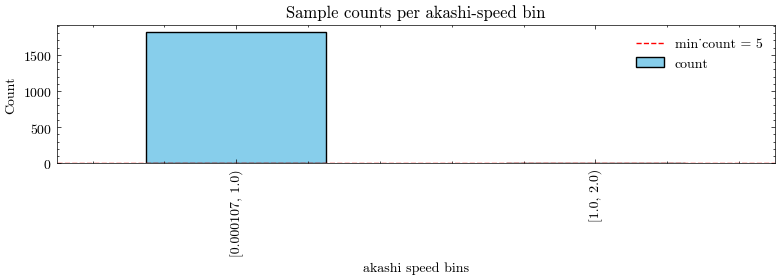

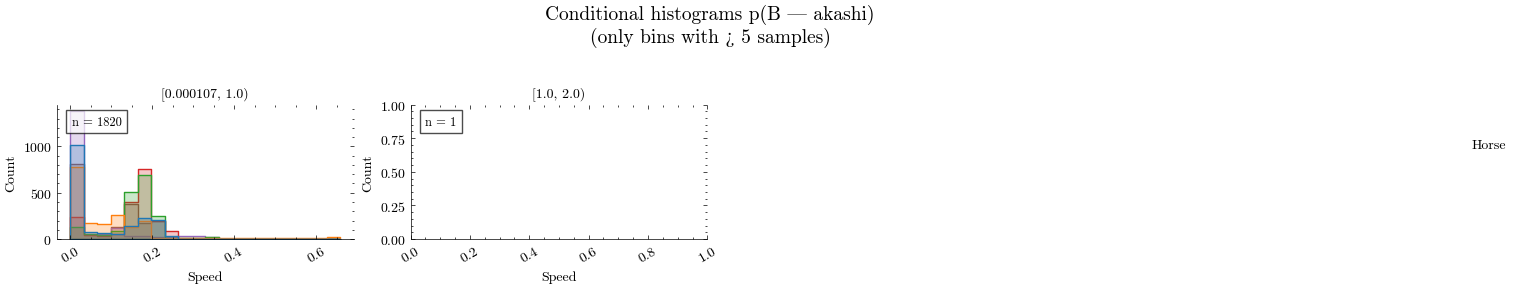

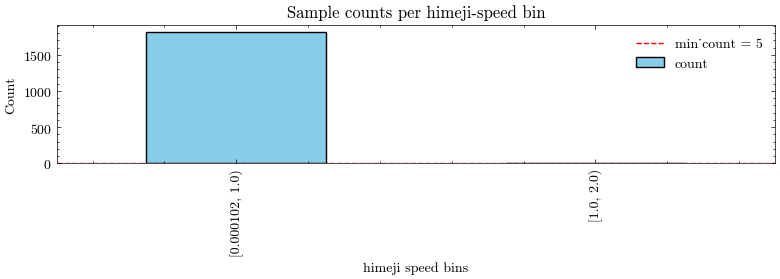

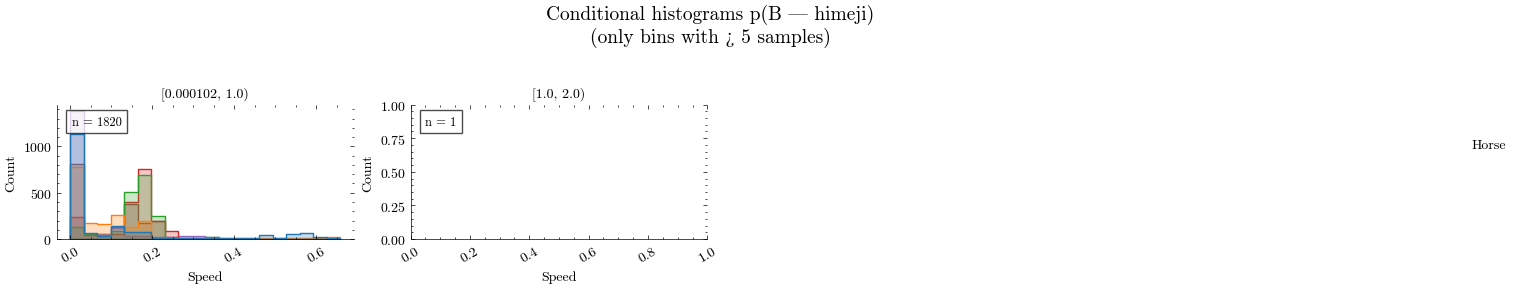

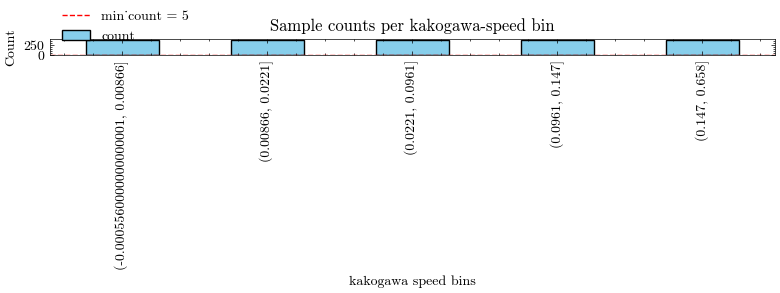

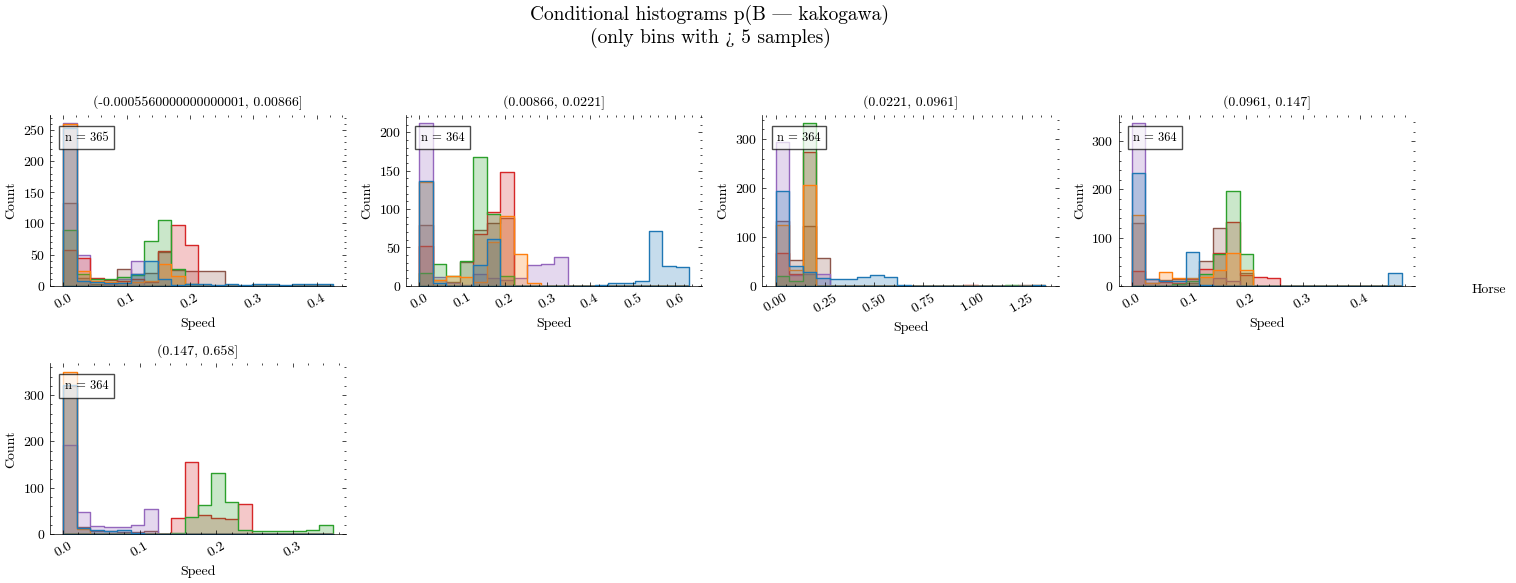

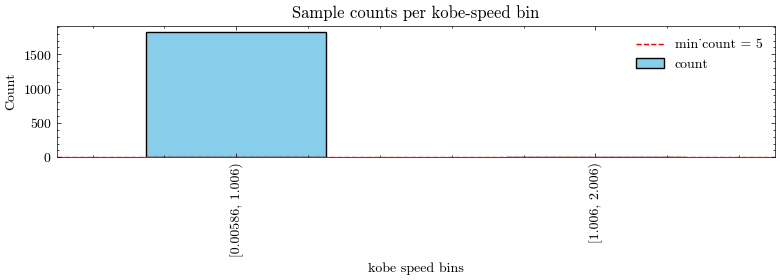

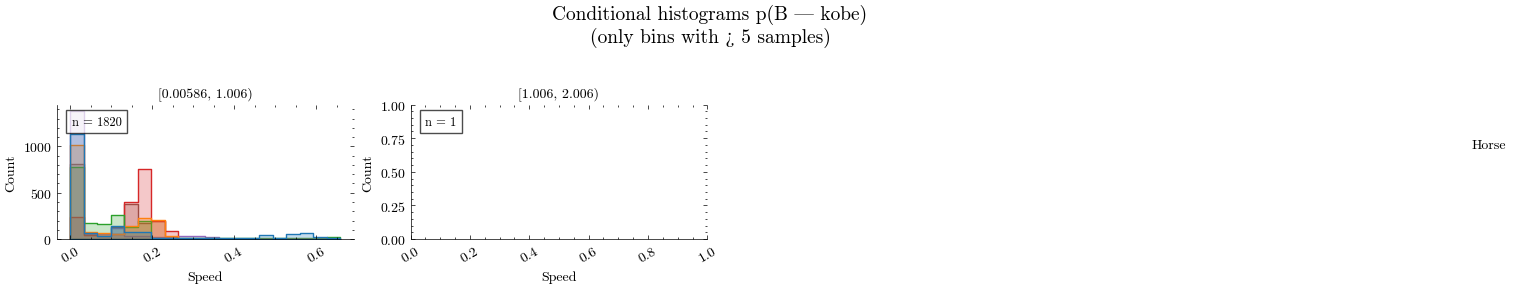

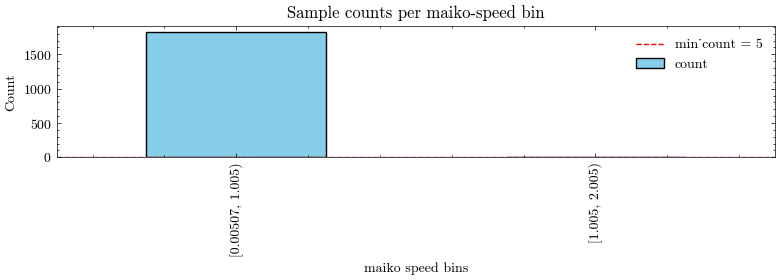

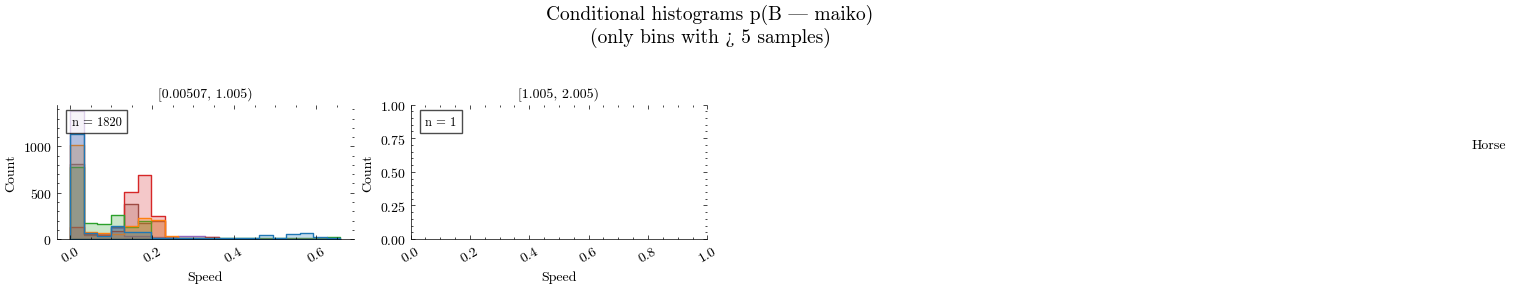

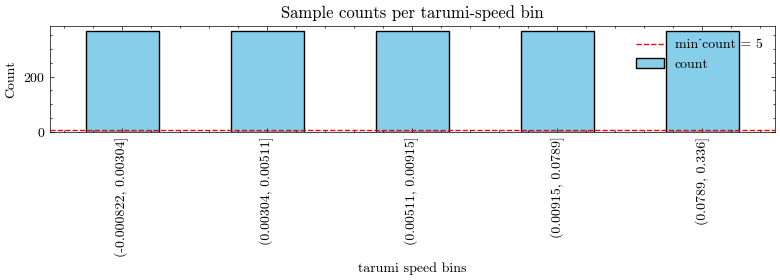

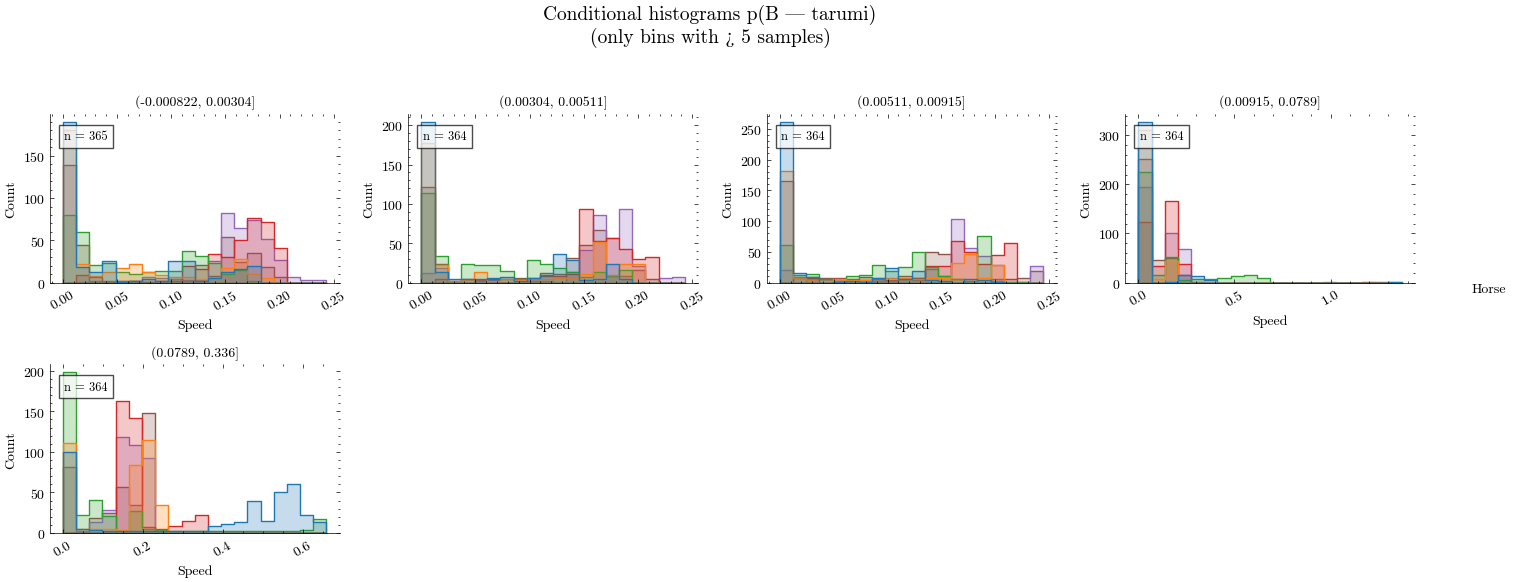

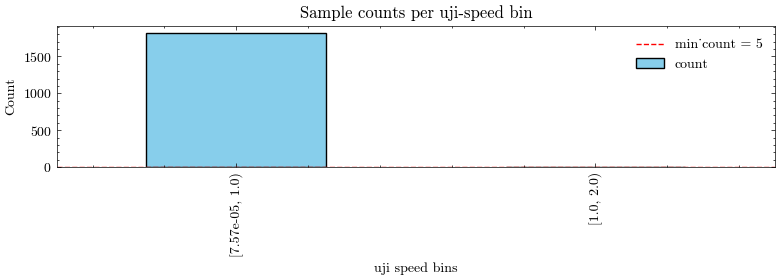

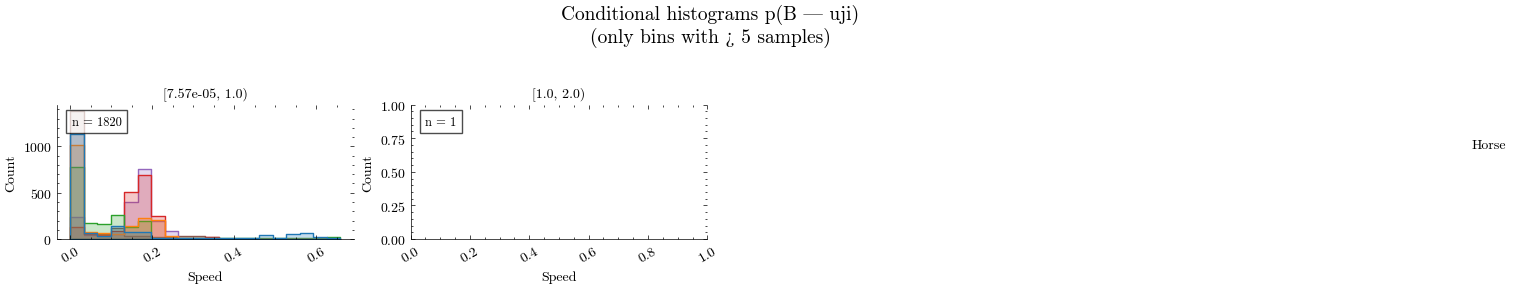

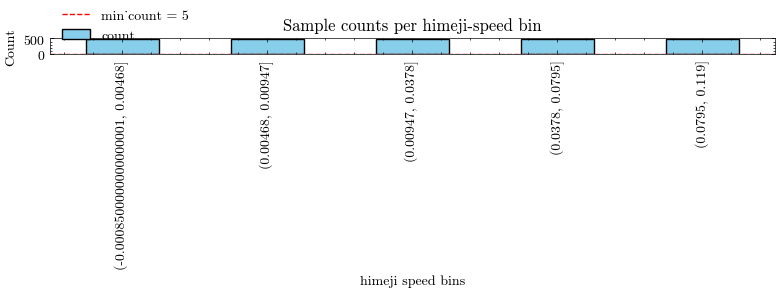

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-45-941537242.py", line 149, in <cell line: 0>
    plot_bin_counts_and_histograms(sp, lead)
  File "/tmp/ipython-input-39-397579294.py", line 59, in plot_bin_counts_and_histograms
    g.map_dataframe(sns.histplot,
  File "/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py", line 832, in map_dataframe
    self._finalize_grid(axis_labels)
  File "/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py", line 862, in _finalize_grid
    self.tight_layout()
  File "/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py", line 123, in tight_layout
    self._figure.tight_layout(*args, **kwargs)
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/figure.py", line 3640, in tight_layout
    engine.execute(self)
  File "/usr/local/lib/python3.11/dist-pack

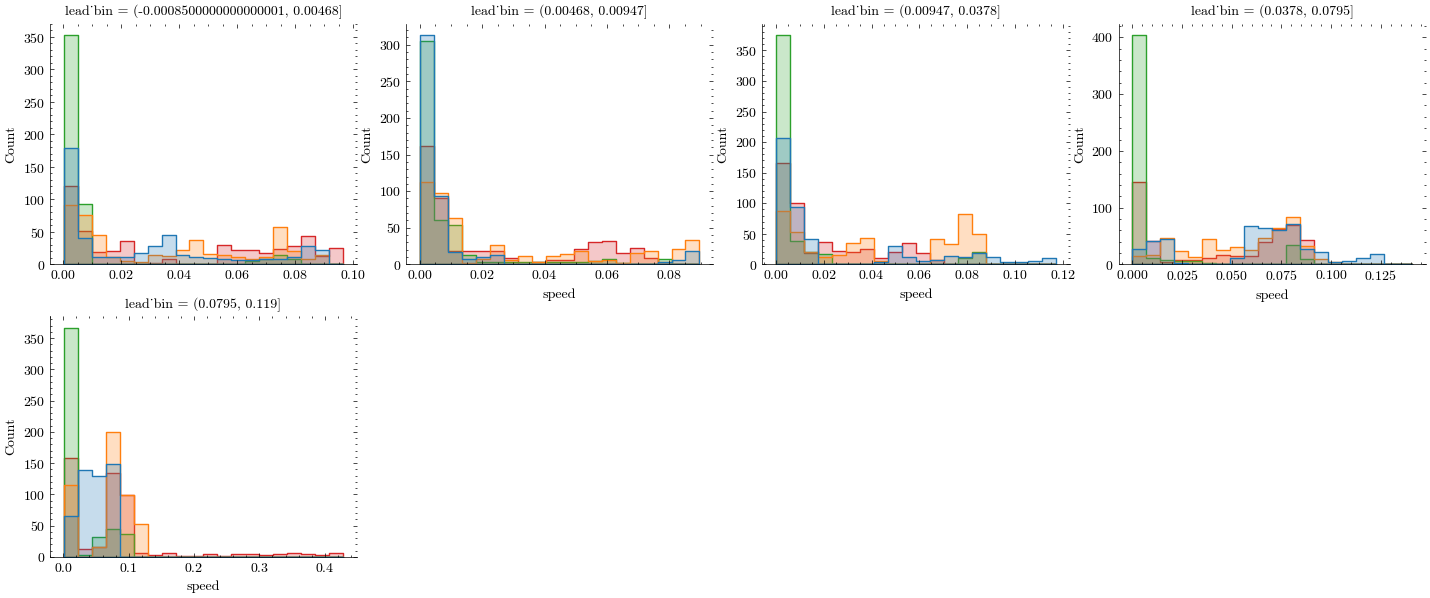

In [ ]:
import os
import re
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from openpyxl import load_workbook

logging.basicConfig(level=logging.INFO,
                    format='%(levelname)s: %(message)s')

def rename_columns(df):
    """
    Robustly rename your raw columns into:
      - time
      - <horse>_x
      - <horse>_y
    Drops any horse for which you don't have both coordinates.
    """
    old_cols = list(df.columns)
    new_cols = []
    for col in old_cols:
        c = str(col).strip()
        # TIME
        if re.match(r"^Time", c, re.IGNORECASE):
            new = "time"

        # already ends _x or _y
        elif re.match(r".+_[xy]$", c, re.IGNORECASE):
            new = c.lower()

        # ends with " X" or " x"
        elif m := re.match(r"(.+)\s+[Xx]$", c):
            base = m.group(1).strip().lower().replace(" ", "_")
            new = f"{base}_x"

        # ends with " Y" or " y"
        elif m := re.match(r"(.+)\s+[Yy]$", c):
            base = m.group(1).strip().lower().replace(" ", "_")
            new = f"{base}_y"

        # fallback: just snake_case it
        else:
            new = c.lower().replace(" ", "_")

        new_cols.append(new)

    df.columns = new_cols

    # now check that every base has both _x and _y
    bases = set(n[:-2] for n in new_cols
                if n.endswith("_x") or n.endswith("_y"))
    bad = [b for b in bases if f"{b}_x" not in new_cols
                       or f"{b}_y" not in new_cols]
    if bad:
        logging.warning(f"dropping unmatched horses: {bad}")
        to_drop = [f"{b}_{s}" for b in bad for s in ("x","y")
                   if f"{b}_{s}" in df.columns]
        df = df.drop(columns=to_drop)

    return df

def read_events(folder_path):
    """
    Read each .xls/.xlsx, rename columns, pull out the herding flag
    from column A’s fill, and return a dict of cleaned DataFrames.
    """
    events = {}
    for fn in os.listdir(folder_path):
        if not fn.lower().endswith((".xls",".xlsx")):
            continue
        path = os.path.join(folder_path, fn)
        raw = pd.read_excel(path)
        df  = rename_columns(raw)

        # get fill-colors from Excel
        wb = load_workbook(path, data_only=True)
        ws = wb.active
        flags = []
        for cell in ws["A"][1:]:
            fg = cell.fill.fgColor
            rgb = fg.rgb if fg.type=="rgb" else None
            flags.append(0 if rgb in (None, "FFFFFF","FFFFFFFF") else 1)

        df = df.iloc[:len(flags)].copy()
        df["herding"] = flags
        events[fn] = df.reset_index(drop=True)

    return events

def compute_speeds(df, dt=0.25):
    horses = sorted({c[:-2] for c in df.columns
                     if c.endswith("_x")})
    times = df["time"].values
    speeds = pd.DataFrame({"time": times[1:]})
    for h in horses:
        dx = df[f"{h}_x"].diff().iloc[1:].values
        dy = df[f"{h}_y"].diff().iloc[1:].values
        speeds[h] = np.hypot(dx, dy) / dt
    return speeds

def plot_conditional_distributions(speeds, lead,
                                   bin_width=1.0, min_count=5,
                                   bins=20, ncols=3):
    df = speeds.copy()
    df["lead_bin"] = pd.cut(df[lead],
                            bins=np.arange(df[lead].min(),
                                           df[lead].max()+bin_width,
                                           bin_width),
                            right=False)
    counts = df["lead_bin"].value_counts()
    valid = counts[counts>=min_count].index.sort_values()
    others = [c for c in df.columns
              if c not in ("time", lead, "lead_bin")]

    n = len(valid)
    nrows = int(np.ceil(n/ncols))
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4*ncols, 3*nrows),
                             sharex=False, sharey=False)
    axes = axes.flatten()
    for ax, b in zip(axes, valid):
        sub = df[df["lead_bin"]==b]
        for h in others:
            sns.histplot(sub[h],
                         bins=bins,
                         element="step",
                         stat="count",
                         ax=ax,
                         label=h,
                         alpha=0.7)
        ax.set_title(f"{lead} in [{b.left:.1f},{b.right:.1f})")
        ax.legend(fontsize=8)
    for ax in axes[n:]:
        ax.axis("off")
    fig.suptitle(f"p(B | {lead})", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

# ——— Main ———
if __name__=="__main__":
    folder = "data"
    events = read_events(folder)
    for fn, df in events.items():
        logging.info(f"{fn}: columns → {df.columns.tolist()}")
        sp = compute_speeds(df, dt=0.25)
        for lead in [c for c in sp.columns if c!="time"]:
            plot_bin_counts_and_histograms(sp, lead)


In [ ]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from openpyxl import load_workbook

def rename_columns(df):
    # robust R-style rename
    df = df.copy()
    cols = list(df.columns)
    new = []
    for c in cols:
        s = str(c).strip()
        if re.match(r"^Time", s, re.IGNORECASE):
            new.append("time")
        elif re.match(r".+_[xy]$", s, re.IGNORECASE):
            new.append(s.lower())
        elif m := re.match(r"(.+)\s+[Xx]$", s):
            new.append(m.group(1).strip().lower().replace(" ", "_") + "_x")
        elif m := re.match(r"(.+)\s+[Yy]$", s):
            new.append(m.group(1).strip().lower().replace(" ", "_") + "_y")
        else:
            new.append(s.lower().replace(" ", "_"))
    df.columns = new

    # drop any half-pairs
    bases = {n[:-2] for n in new if n.endswith(("_x","_y"))}
    bad = [b for b in bases
           if f"{b}_x" not in new or f"{b}_y" not in new]
    for b in bad:
        for suffix in ("_x","_y"):
            col = b+suffix
            if col in df:
                df.drop(columns=col, inplace=True)
    return df

def read_events(folder):
    ev = {}
    for fn in os.listdir(folder):
        if not fn.lower().endswith((".xls","xlsx")): continue
        path = os.path.join(folder, fn)
        raw = pd.read_excel(path)
        df  = rename_columns(raw)
        wb  = load_workbook(path, data_only=True)
        ws  = wb.active
        flags = []
        for cell in ws["A"][1:]:
            fg = cell.fill.fgColor
            rgb = fg.rgb if fg.type=="rgb" else None
            flags.append(0 if rgb in (None,"FFFFFF","FFFFFFFF") else 1)
        df = df.iloc[:len(flags)].copy()
        df["herding"] = flags
        ev[fn] = df.reset_index(drop=True)
    return ev

def compute_speeds(df, dt=0.25):
    horses = sorted({c[:-2] for c in df.columns if c.endswith("_x")})
    t = df["time"].values
    speeds = pd.DataFrame({"time": t[1:]})
    for h in horses:
        dx = df[f"{h}_x"].diff().iloc[1:].values
        dy = df[f"{h}_y"].diff().iloc[1:].values
        speeds[h] = np.hypot(dx, dy)/dt
    return speeds

def make_pdf(events, out_pdf="conditional_distributions.pdf",
             quantiles=5, min_count=5, bins=20):
    with PdfPages(out_pdf) as pdf:
        for fn, df in sorted(events.items()):
            # strip extension for title
            title = os.path.splitext(fn)[0]

            sp = compute_speeds(df, dt=0.25)
            leads = [c for c in sp.columns if c!="time"]

            for lead in leads:
                data = sp[[lead]].copy()
                # 5 quantile bins
                data["bin"] = pd.qcut(data[lead], q=quantiles, duplicates="drop")
                counts = data["bin"].value_counts().sort_index()

                # --- page 1: bar chart of counts ---
                fig, ax = plt.subplots(figsize=(6,3))
                counts.plot.bar(ax=ax, edgecolor="k")
                ax.axhline(min_count, color="r", ls="--",
                           label=f"min_count = {min_count}")
                ax.set_title(f"{title}: counts per quantile-bin of {lead}")
                ax.set_xlabel(f"{lead} speed bin")
                ax.set_ylabel("Count")
                ax.legend()
                pdf.savefig(fig); plt.close(fig)

                # --- pages 2..: one histogram per bin ---
                valid = counts[counts>=min_count].index
                others = [h for h in sp.columns if h not in ("time",lead)]
                for b in valid:
                    subset = sp.loc[data["bin"]==b, others]
                    fig, ax = plt.subplots(figsize=(5,4))
                    for h in others:
                        ax.hist(subset[h], bins=bins,
                                alpha=0.5,
                                label=h,
                                edgecolor="none")
                    ax.set_title(f"{title}: p(B|{lead} in {b})")
                    ax.set_xlabel("Speed")
                    ax.set_ylabel("Count")
                    ax.legend(fontsize=6)
                    pdf.savefig(fig); plt.close(fig)

    print(f"✅ saved PDF → {out_pdf}")

if __name__ == "__main__":
    events = read_events("data")
    make_pdf_grouped(events)


In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def make_pdf_grouped(events,
                     out_pdf="conditional_distributions_grouped.pdf",
                     quantiles=5, min_count=5, bins=20,
                     cols=3):
    with PdfPages(out_pdf) as pdf:
        for fn, df in sorted(events.items()):
            region = clean_event_name(fn)
            speeds = compute_speeds(df, dt=0.25)
            leads  = [c for c in speeds.columns if c!="time"]

            for lead in leads:
                # quantile‐bin the lead
                tmp = speeds[[lead]].copy()
                tmp["bin"] = pd.qcut(tmp[lead], q=quantiles, duplicates="drop")
                counts = tmp["bin"].value_counts().sort_index()
                valid  = counts[counts>=min_count].index

                # set up figure + GridSpec
                fig = plt.figure(figsize=(8, 10))
                gs  = fig.add_gridspec(
                    nrows=3, ncols=cols,
                    # make the top row a bit shorter,
                    # give more space between rows
                    height_ratios=[0.6, 1, 1],
                    hspace=0.7
                )

                # — Top bar‐chart (row 0 spans all cols)
                ax0 = fig.add_subplot(gs[0, :])
                counts.plot.bar(ax=ax0, color="skyblue", edgecolor="k")
                ax0.axhline(min_count, color="r", ls="--",
                            label=f"min_count = {min_count}")
                ax0.set_title(f"{region}: sample counts for {lead}",
                              fontsize=12, pad=12)
                ax0.set_xlabel(f"{lead} speed quantile‐bins")
                ax0.set_ylabel("Count")
                ax0.legend()

                # — Bottom: histograms in rows 1 and 2 —
                others = [h for h in speeds.columns if h not in ("time", lead)]
                for i, iv in enumerate(valid):
                    row = 1 + (i // cols)
                    col = i % cols
                    ax = fig.add_subplot(gs[row, col])

                    # nice interval label
                    L, R = iv.left, iv.right
                    iv_label = f"{L:.2f} – {R:.2f}"

                    subset = speeds.loc[tmp["bin"]==iv, others]
                    for h in others:
                        ax.hist(subset[h],
                                bins=bins,
                                alpha=0.5,
                                label=h,
                                edgecolor="none")
                    ax.set_title(iv_label, fontsize=10, pad=6)
                    ax.set_xlabel("Speed")
                    ax.set_ylabel("Count")
                    if i == 0:
                        ax.legend(fontsize=6, loc="upper right")

                # overall suptitle
                fig.suptitle(f"{region} — conditional p(B | {lead})",
                             fontsize=14, y=0.96)

                pdf.savefig(fig)
                plt.close(fig)

    print(f"✅ wrote grouped PDF → {out_pdf}")

def clean_event_name(fn):
    """
    e.g. “filtered_fullsampled_inverness_0011-1.xlsx” → “Inverness”
    """
    base = os.path.splitext(fn)[0]
    # capture the word immediately after “filtered_fullsampled_”
    m = re.match(r"^filtered_fullsampled_([^_]+)", base, re.IGNORECASE)
    region = m.group(1) if m else base
    return region.title()
